In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
import sklearn
import math

# Aux data preparation functions

In [2]:
def parse_emotion(emotion,emo_dict):
    return emo_dict[emotion]
def process_pixels(pixel_str):
    pixel_lst=[int(px) for px in pixel_str.split()]
    return pixel_lst
def show_some_emotion(df,num=[3,5]):
    faces=np.random.choice(range(len(df)),size=num[0]*num[1],replace=False)
    fig,axes=plt.subplots(num[0],num[1],figsize=(num[1]*2.5,num[0]*2.5))
    for i in range(num[0]):
        for j in range(num[1]):
            face=faces[i*num[1]+j]
            axes[i][j].imshow(np.array(df['pixels'].iloc[face]).reshape(48,48),cmap='gray')
            axes[i][j].set_title(df['emotion'].iloc[face])
    plt.tight_layout()
    plt.show()
def filter_emotions(df,keep_emotions):
    return df[df['emotion'].isin(keep_emotions)]
def equalize_groups(df,label):
    largest_group=df.groupby(label).count().max()[0]
    upscaled_groups=[]
    for _,group in df.groupby(label):
        group_ratio=int(round(1.0*largest_group/len(group)))
        upscaled_groups.extend([group]*group_ratio)
    return pd.concat(upscaled_groups,axis=0,ignore_index=True)
def normalize_pixels(pixel_lst,factor=255):
    if factor=='norm':
        px_avg=np.mean(pixel_lst)
        px_std=np.std(pixel_lst)
        pixel_lst=[(1.0*px-px_avg)/px_std for px in pixel_lst]
    elif factor=='max':
        px_max=np.max(pixel_lst)
        pixel_lst=[1.0*px/px_max for px in pixel_lst]
    else:
        pixel_lst=[1.0*px/factor for px in pixel_lst]
    return pixel_lst
def prepare_data(faces_file,emo_dict,
                 emo_filter=False,
                 equalize=True,
                 sample=False,random_state=None,
                 plot_sample=[3,5],
                 normalize=255):
    df=pd.read_csv(faces_file,usecols=[0,1])
    df['emotion']=df['emotion'].map(lambda emotion: parse_emotion(emotion,emo_dict))
    if emo_filter!=False:
        df=filter_emotions(df,keep_emotions)
    if equalize:
        df=equalize_groups(df,'emotion')
    if sample:
        df=df.sample(sample,random_state=random_state)
    df['pixels']=df['pixels'].map(process_pixels)
    if plot_sample!=False:
        show_some_emotion(df,plot_sample)
    if normalize:
        df['pixels']=df['pixels'].map(lambda pixels: normalize_pixels(pixels,factor=normalize))
    X=np.array(df['pixels'].values.tolist())
    labels=list(df['emotion'].unique())
    Y=df['emotion'].map(lambda x: labels.index(x)).values
    return X,Y

# Aux NN functions

In [3]:
def one_hot_encoder(v):
    return np.eye(v.max()+1)[v]
def one_hot_decoder(v):
    return np.argmax(v,axis=1)
def sigmoid(v,derivate=False):
    if derivate:
        return v*(1-v)
    else:
        return 1/(1+np.exp(-v))
def relu(v,derivate=False):
    if derivate:
        return (v>0)
    else:
        return v*(v>0)
def tanh(v,derivate=False):
    if derivate:
        return 1-v*v
    else:
        return np.tanh(v)
def softmax(v):
    expv=np.exp(v)
    if v.shape[0]>1:
        return expv/expv.sum(axis=1,keepdims=True)
    else:
        return expv/expv.sum(axis=1)
def cross_entropy_cost(Y,P):
    return -(Y*np.log(P)).mean()
def accuracy(Y,P):
    return (Y==P).mean()
def rmse(Y,P):
    return np.sqrt(((P-Y)**2).mean())

# La classe

In [4]:
class NN_01(object):
    def __init__(self,
                 net_structure,
                 f_encode_Y=one_hot_encoder,
                 f_decode_Y=one_hot_decoder,
                 f_transfer=sigmoid,
                 f_output=lambda v: softmax(sigmoid(v)),
                 f_cost=cross_entropy_cost,
                 f_accuracy=accuracy):
        self.net_structure=net_structure
        self.f_encode_Y=f_encode_Y
        self.f_decode_Y=f_decode_Y
        self.f_transfer=f_transfer
        self.f_output=f_output
        self.f_cost=f_cost
        self.f_accuracy=f_accuracy
    def train(self,X,Y,W_0=None,
              frac_test=0.2,random_state=None,
              learning_rate=10e-7,regularization=0,num_rounds=100001,
              report_step=100,print_every=5000,print_acc=True,plot_cost=True):
        self.training_report=[]
        X,Y=sklearn.utils.shuffle(X,Y,random_state=random_state)
        num_test=int(frac_test*X.shape[0])
        X_train,Y_train=X[:-num_test],Y[:-num_test]
        X_test,Y_test=X[-num_test:],Y[-num_test:]
        eY_train,eY_test=self.f_encode_Y(Y_train),self.f_encode_Y(Y_test)
        if W_0!=None:
            self.W=W_0
        else:
            self.W=self.populate_W(X_train,eY_train)
        peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
        global_start=datetime.datetime.now()
        reporting_start=datetime.datetime.now()
        for n in range(num_rounds):
            delta=peY_train[-1]-eY_train
            for l in reversed(range(len(self.W))):
                gradient,new_delta=self.derivate_layer(self.W[l],peY_train[l],delta)
                delta=new_delta
                self.W[l]=self.W[l]*(1-learning_rate*regularization)-learning_rate*gradient
            peY_train,peY_test=self.feed_forward(X_train),self.feed_forward(X_test)
            if n % report_step==0:
                c_train,c_test=self.f_cost(eY_train,peY_train[-1]),self.f_cost(eY_test,peY_test[-1])
                pY_train,pY_test=self.f_decode_Y(peY_train[-1]),self.f_decode_Y(peY_test[-1])
                acc_train,acc_test=self.f_accuracy(Y_train,pY_train),self.f_accuracy(Y_test,pY_test)
                global_duration=(datetime.datetime.now()-global_start).total_seconds()
                if print_every and n % print_every==0:
                    global_left=global_duration*(num_rounds-n+1)/(n+1)
                    reporting_duration=(datetime.datetime.now()-reporting_start).total_seconds()
                    reporting_start=datetime.datetime.now()
                    print('{:5d} '.format(n)),
                    print('{:0.5f} {:0.5f} '.format(acc_train,acc_test)),
                    print('{:0.5f} {:0.5f} '.format(c_train,c_test)),
                    print('{:7.2f} {:7.2f}  {:7.2f}'.format(reporting_duration,global_duration,global_left))
                self.training_report.append([n,acc_train,acc_test,c_train,c_test,global_duration])
        if plot_cost:
            plt.plot([r[3] for r in self.training_report])
            plt.plot([r[4] for r in self.training_report])
            plt.show()
    def populate_W(self,X,T):
        net_structure=[X[0].size]+self.net_structure+[T[0].size]
        W=[]
        for i in range(len(net_structure)-1):
            nodes_this=net_structure[i]+1
            nodes_next=net_structure[i+1]
            W.append(np.random.randn(nodes_this,nodes_next)/np.sqrt(nodes_this+nodes_next))
        return W
    def derivate_layer(self,W_layer,layer,delta):
        next_delta=delta.dot(W_layer[:-1,:].T)*self.f_transfer(layer,derivate=True)
        layer=np.append(layer,np.ones((layer.shape[0],1)),1)
        return layer.T.dot(delta),next_delta
    def predict(self,X):
        return self.f_decode_Y(self.feed_forward(X))
    def feed_forward(self,X):
        v=[X]
        for l in range(len(self.W)-1):
            v.append(self.f_transfer(self.process_layer(v[-1],self.W[l])))
        v.append(self.f_output(self.process_layer(v[-1],self.W[-1])))
        return v
    def process_layer(self,X,W):
        X=np.append(X,np.ones((X.shape[0],1)),1)
        return X.dot(W)

# Data preparation

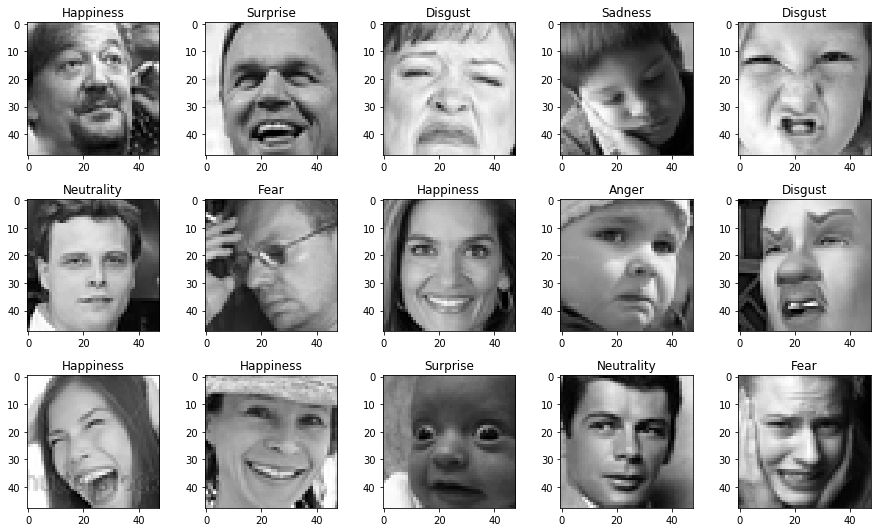

((58168, 2304), (58168,))

In [5]:
file_name='data/fer2013.csv.bz2'
emo_dict={0:'Anger',1:'Disgust',2:'Fear',3:'Happiness',4:'Sadness',5:'Surprise',6:'Neutrality'}
X,Y=prepare_data(file_name,emo_dict,
                 emo_filter=False,
                 equalize=True,
                 sample=False,random_state=None,
                 plot_sample=[3,5],
                 normalize=255)
X.shape,Y.shape

# Multi class classifier, 16 nodes

## Sigmoid

In [6]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.15502 0.15250  0.27727 0.27721    34.58   34.76  34829.53
  100  0.22115 0.21877  0.27090 0.27089   406.22  441.00  3938.47
  200  0.19764 0.19187  0.26994 0.27022   394.40  835.40  3333.30
  300  0.26524 0.26889  0.26463 0.26473   394.92 1230.32  2869.39
  400  0.28490 0.28548  0.26164 0.26204   394.34 1624.66  2439.02
  500  0.23952 0.23691  0.26743 0.26758   392.16 2016.83  2020.85
  600  0.25860 0.25282  0.26742 0.26799   393.06 2409.88  1611.93
  700  0.27044 0.26666  0.26108 0.26159   386.59 2796.48  1204.76
  800  0.25757 0.25170  0.26368 0.26423   345.23 3141.70   792.29
  900  0.28392 0.27921  0.26030 0.26085   341.94 3483.64   394.37
 1000  0.29135 0.28531  0.25896 0.25957   349.67 3833.32     7.66


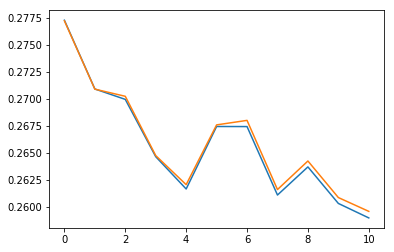

CPU times: user 1h 58min 23s, sys: 45min 56s, total: 2h 44min 19s
Wall time: 1h 5min


In [7]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [8]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.15197 0.15138  0.27668 0.27663     6.09    6.09  6103.39
  100  0.22274 0.22488  0.27074 0.27031   404.22  410.30  3664.25
  200  0.26494 0.26537  0.26639 0.26579   379.73  790.04  3152.29
  300  0.24410 0.24439  0.26586 0.26527   312.86 1102.90  2572.21
  400  0.24087 0.23803  0.26496 0.26431   313.35 1416.24  2126.13
  500  0.24124 0.24009  0.26447 0.26374   314.32 1730.57  1734.02
  600  0.24197 0.24284  0.26444 0.26365   312.84 2043.41  1366.81
  700  0.24517 0.24559  0.26466 0.26387   313.03 2356.44  1015.19
  800  0.25248 0.25196  0.26501 0.26434   312.09 2668.53   672.96


/home/ggomarr/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


  900  0.25570 0.25780  0.26586 0.26535   339.92 3008.45   340.58
 1000  0.25701 0.25840  0.26664 0.26619   331.87 3340.32     6.67


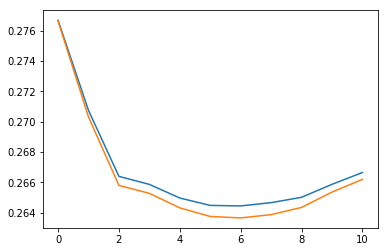

CPU times: user 1h 51min 51s, sys: 40min 46s, total: 2h 32min 38s
Wall time: 1h 2min 12s


In [9]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [10]:
my_NN=NN_01(net_structure=[16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.17576 0.17734  0.27586 0.27580     4.69    4.69  4697.86
  100  0.22170 0.21680  0.27082 0.27114   358.34  363.03  3242.07
  200  0.25460 0.25196  0.26739 0.26791   355.75  718.78  2867.97
  300  0.27532 0.26442  0.26625 0.26689   355.79 1074.57  2506.14
  400  0.28381 0.27852  0.26439 0.26524   353.11 1427.68  2143.31
  500  0.28312 0.27654  0.26311 0.26413   347.64 1775.33  1778.87
  600  0.28116 0.27388  0.26207 0.26327   365.24 2140.57  1431.80
  700  0.28177 0.27439  0.26120 0.26254   334.78 2475.35  1066.41
  800  0.28357 0.27680  0.26045 0.26191   329.73 2805.08   707.40
  900  0.28392 0.27628  0.25980 0.26135   328.48 3133.56   354.74
 1000  0.27448 0.27267  0.26042 0.26131   329.61 3463.17     6.92


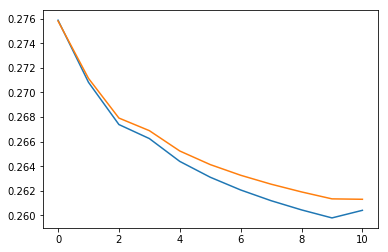

CPU times: user 1h 55min 14s, sys: 40min 52s, total: 2h 36min 6s
Wall time: 57min 52s


In [11]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Multi class classifier, 32 nodes

## Sigmoid

In [12]:
my_NN=NN_01(net_structure=[32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.15900 0.16032  0.27621 0.27624     4.29    4.29  4300.52
  100  0.25529 0.25170  0.26762 0.26787   355.95  360.24  3217.22
  200  0.27177 0.26984  0.26370 0.26388   350.51  710.75  2835.92
  300  0.25811 0.25041  0.26563 0.26578   349.23 1059.98  2472.11
  400  0.28692 0.27981  0.26086 0.26148   350.96 1410.94  2118.17
  500  0.24659 0.24259  0.26435 0.26417   346.30 1757.24  1760.75
  600  0.26359 0.26064  0.26396 0.26434   346.46 2103.70  1407.13
  700  0.25884 0.25058  0.26106 0.26183   346.28 2449.98  1055.48
  800  0.28458 0.27723  0.26236 0.26309   348.52 2798.49   705.74
  900  0.26468 0.25926  0.26229 0.26304   348.44 3146.93   356.26
 1000  0.27366 0.26794  0.26264 0.26342   345.37 3492.30     6.98


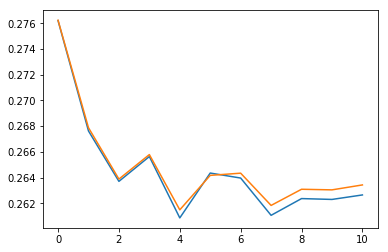

CPU times: user 2h 6min 8s, sys: 35min 51s, total: 2h 42min
Wall time: 58min 20s


In [13]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [6]:
my_NN=NN_01(net_structure=[32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.16323 0.15714  0.27772 0.27787    17.03   17.04  17075.68
  100  0.21940 0.21594  0.27117 0.27178   317.82  334.89  2990.83
  200  0.26109 0.25393  0.26663 0.26754   312.06  646.95  2581.36
  300  0.27031 0.25909  0.26433 0.26552   310.96  957.91  2234.06
  400  0.27281 0.26098  0.26285 0.26409   311.05 1268.96  1905.03
  500  0.27366 0.26390  0.26227 0.26362   312.07 1581.03  1584.19
  600  0.27223 0.26193  0.26222 0.26364   309.69 1890.72  1264.67
  700  0.26928 0.26158  0.26253 0.26395   309.03 2199.75   947.68
  800  0.26730 0.25754  0.26316 0.26450   308.43 2508.18   632.52
  900  0.25297 0.24138  0.26417 0.26547   304.19 2812.37   318.38


/home/ggomarr/.local/lib/python2.7/site-packages/ipykernel/__main__.py:9: RuntimeWarning: overflow encountered in exp


 1000  0.24438 0.23743  0.26522 0.26654   300.55 3112.92     6.22


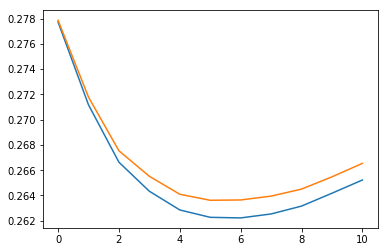

CPU times: user 2h 1min 30s, sys: 34min 46s, total: 2h 36min 17s
Wall time: 52min 46s


In [7]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [8]:
my_NN=NN_01(net_structure=[32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.16770 0.17089  0.27551 0.27565    18.94   18.92  18956.34
  100  0.23393 0.22694  0.26939 0.26991   342.24  361.18  3225.61
  200  0.27934 0.27783  0.26558 0.26617   342.20  703.39  2806.55
  300  0.26743 0.25849  0.26492 0.26573   341.36 1044.75  2436.59
  400  0.27031 0.26047  0.26322 0.26411   341.75 1386.50  2081.48
  500  0.27519 0.26416  0.26194 0.26290   343.17 1729.67  1733.13
  600  0.27856 0.26837  0.26093 0.26196   341.74 2071.41  1385.54
  700  0.28207 0.27052  0.26011 0.26120   342.76 2414.17  1040.06
  800  0.28501 0.27448  0.25940 0.26057   341.45 2755.62   694.93
  900  0.28692 0.27577  0.25880 0.26004   340.64 3096.27   350.52
 1000  0.28830 0.27680  0.25828 0.25960   342.05 3438.32     6.87


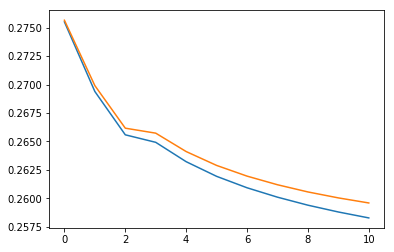

CPU times: user 2h 5min 53s, sys: 36min 11s, total: 2h 42min 5s
Wall time: 1h 3min 53s


In [9]:
%%time
my_NN.train(X,Y,learning_rate=10e-7,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Multi class classifier, 16 + 16 nodes

## Sigmoid

In [10]:
my_NN=NN_01(net_structure=[16,16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.17701 0.17235  0.27589 0.27604     3.39    3.39  3400.73
  100  0.19143 0.19247  0.27479 0.27490   338.88  342.27  3056.74
  200  0.19188 0.19316  0.27266 0.27311   338.08  680.35  2714.63
  300  0.21986 0.21293  0.27074 0.27143   336.50 1016.85  2371.53
  400  0.22035 0.22127  0.26861 0.26914   338.48 1355.33  2034.69
  500  0.22435 0.22110  0.26812 0.26896   337.46 1692.79  1696.17
  600  0.23266 0.23072  0.27253 0.27336   336.97 2029.76  1357.68
  700  0.22755 0.22471  0.26967 0.27046   339.31 2369.07  1020.63
  800  0.25140 0.24817  0.26740 0.26856   339.56 2708.63   683.08
  900  0.19620 0.19685  0.27270 0.27326   337.22 3045.85   344.81
 1000  0.20385 0.20244  0.27082 0.27122   337.31 3383.17     6.76


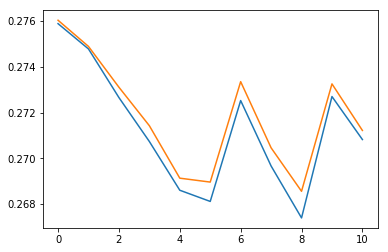

CPU times: user 2h 2min 43s, sys: 38min 8s, total: 2h 40min 52s
Wall time: 56min 29s


In [11]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-6,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [12]:
my_NN=NN_01(net_structure=[16,16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.16555 0.16496  0.27877 0.27877     2.70    2.70  2706.16
  100  0.19753 0.19436  0.27386 0.27412   273.06  275.76  2462.74
  200  0.20686 0.20476  0.27257 0.27284   273.22  548.99  2190.48
  300  0.21410 0.21379  0.27099 0.27126   271.20  820.19  1912.87
  400  0.22570 0.22565  0.26914 0.26940   272.35 1092.54  1640.17
  500  0.23885 0.23932  0.26727 0.26752   293.53 1386.07  1388.84
  600  0.21188 0.20734  0.26876 0.26914   319.35 1705.42  1140.73
  700  0.20039 0.19857  0.26821 0.26853   297.82 2003.24   863.02
  800  0.19128 0.18938  0.26833 0.26856   271.57 2274.81   573.67
  900  0.18212 0.18078  0.26927 0.26972   271.88 2546.70   288.31
 1000  0.21981 0.22221  0.27501 0.27565   271.49 2818.18     5.63


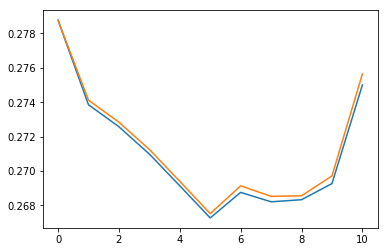

CPU times: user 1h 54min 17s, sys: 32min 7s, total: 2h 26min 24s
Wall time: 47min 4s


In [13]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [14]:
my_NN=NN_01(net_structure=[16,16],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.10588 0.10900  0.27922 0.27919     3.32    3.32  3324.87
  100  0.17806 0.17794  0.27500 0.27532   329.28  332.60  2970.36
  200  0.18322 0.18250  0.27429 0.27464   332.36  664.96  2653.22
  300  0.20060 0.20416  0.27345 0.27377   329.60  994.56  2319.55
  400  0.20875 0.21121  0.27241 0.27270   331.07 1325.63  1990.10
  500  0.22727 0.23064  0.27118 0.27141   329.84 1655.47  1658.78
  600  0.24285 0.24628  0.26971 0.26988   331.66 1987.13  1329.16
  700  0.26013 0.26588  0.26799 0.26807   330.55 2317.68   998.49
  800  0.28187 0.29115  0.26608 0.26607   330.86 2648.54   667.92
  900  0.30115 0.31041  0.26415 0.26404   330.43 2978.97   337.24
 1000  0.27775 0.28823  0.26389 0.26343   330.86 3309.83     6.61


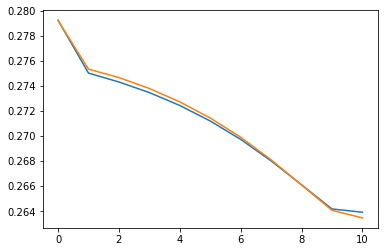

CPU times: user 2h 2min 7s, sys: 37min 46s, total: 2h 39min 54s
Wall time: 55min 17s


In [15]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

# Multi class classifier, 32 + 32 nodes

## Sigmoid

In [6]:
my_NN=NN_01(net_structure=[32,32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=sigmoid,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.17582 0.17708  0.27780 0.27773    45.46   45.49  45578.75
  100  0.17591 0.17708  0.27515 0.27512   360.75  406.26  3628.15
  200  0.18582 0.18662  0.27443 0.27440   360.16  766.41  3058.02
  300  0.20539 0.21018  0.27192 0.27191   359.03 1125.44  2624.79
  400  0.21388 0.21319  0.26920 0.26897   360.60 1486.04  2230.91
  500  0.26679 0.27284  0.26516 0.26499   360.51 1846.55  1850.24
  600  0.24966 0.24938  0.26641 0.26682   360.18 2206.73  1476.05
  700  0.26720 0.26949  0.26347 0.26377   365.41 2572.15  1108.11
  800  0.22733 0.22918  0.27150 0.27176   367.88 2940.03   741.43
  900  0.28484 0.29012  0.26139 0.26108   361.02 3301.05   373.70
 1000  0.23320 0.23777  0.26866 0.26827   363.76 3664.81     7.32


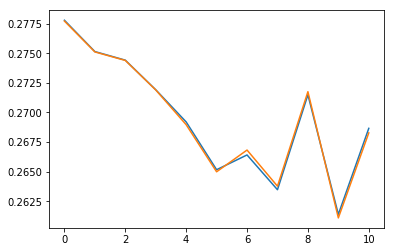

CPU times: user 2h 11min 7s, sys: 43min 35s, total: 2h 54min 43s
Wall time: 1h 2min


In [7]:
%%time
my_NN.train(X,Y,learning_rate=10e-6,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Relu

In [8]:
my_NN=NN_01(net_structure=[32,32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=relu,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.16226 0.17235  0.27759 0.27749    15.29   15.30  15329.49
  100  0.18556 0.18809  0.27431 0.27403   337.61  352.92  3151.84
  200  0.21165 0.21233  0.27302 0.27275   329.05  681.98  2721.12
  300  0.22256 0.22711  0.27118 0.27090   315.51  997.48  2326.36
  400  0.25117 0.25178  0.26856 0.26825   298.31 1295.80  1945.31
  500  0.27059 0.27198  0.26550 0.26518   296.36 1592.16  1595.34
  600  0.23314 0.23270  0.26823 0.26818   296.36 1888.52  1263.20
  700  0.22445 0.22342  0.26798 0.26794   296.99 2185.51   941.55
  800  0.21412 0.21499  0.26962 0.26983   296.24 2481.75   625.86
  900  0.19916 0.19634  0.27172 0.27128   296.23 2777.98   314.49
 1000  0.21618 0.20854  0.27532 0.27575   296.98 3074.96     6.14


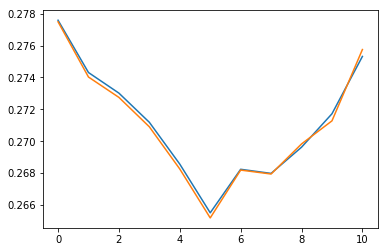

CPU times: user 2h 5min 13s, sys: 37min 48s, total: 2h 43min 2s
Wall time: 57min 48s


In [9]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)

## Tanh

In [6]:
my_NN=NN_01(net_structure=[32,32],
            f_encode_Y=one_hot_encoder,
            f_decode_Y=one_hot_decoder,
            f_transfer=tanh,
            f_output=lambda v: softmax(sigmoid(v)),
            f_cost=cross_entropy_cost,
            f_accuracy=accuracy)

    0  0.16353 0.16728  0.27675 0.27678    56.15   56.28  56387.71
  100  0.18225 0.18086  0.27366 0.27352   382.07  438.38  3915.02
  200  0.21178 0.21585  0.27185 0.27170   371.71  810.09  3232.30
  300  0.23847 0.23923  0.26972 0.26957   371.25 1181.34  2755.16
  400  0.27452 0.27757  0.26733 0.26718   369.88 1551.22  2328.76
  500  0.28985 0.29176  0.26499 0.26486   369.44 1920.66  1924.49
  600  0.29642 0.29683  0.26297 0.26289   368.16 2288.82  1530.96
  700  0.27399 0.27009  0.26380 0.26381   365.65 2654.47  1143.58
  800  0.28073 0.27723  0.26268 0.26271   366.15 3020.62   761.76
  900  0.28493 0.28273  0.26181 0.26185   363.44 3384.07   383.10
 1000  0.28114 0.27723  0.26094 0.26124   362.39 3746.46     7.49


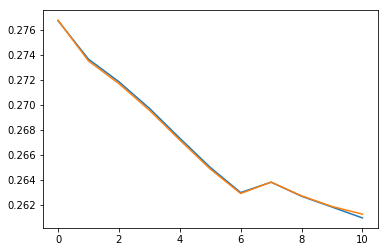

CPU times: user 2h 9min 39s, sys: 48min 23s, total: 2h 58min 3s
Wall time: 1h 3min 24s


In [7]:
%%time
my_NN.train(X,Y,learning_rate=5*10e-8,regularization=0.1,num_rounds=1001,print_every=100,
            frac_test=0.2,W_0=None,random_state=None,report_step=100,print_acc=True,plot_cost=True)